In [1]:
import numpy as np
import cvxpy as cp
import torch
from torch.autograd import Variable
from torch.autograd.grad_mode import no_grad
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, patches

In [2]:
dim = 2
eps = 0.1

Q =  np.array([[2, 0], [0, 1]])

def fx(x, pkg=np):
    if pkg==np:
        cost = 0.5 * x.T @ Q @ x
    else:
        cost = 0.5 * pkg.t(x) @ pkg.from_numpy(Q.astype('float')).float() @ x
    return cost

In [3]:
class BB_node:
    def __init__(self, up=None, low=None, coord_up=None, coord_low=None):
        self.upper = up
        self.lower = low
        self.coord_upper = np.array(coord_up, dtype=float)
        self.coord_lower = np.array(coord_low, dtype=float)
        self.score = self.calc_score()
    
    def calc_score(self):
        # Temp scoring function
        if self.upper == None:
            return None
        
        return np.max(self.coord_upper - self.coord_lower)

    def __repr__(self):
        return str(self.coord_lower) + ' ≤ ' + str(self.coord_upper)

In [4]:
def plot_space(space):
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111)
    rectangle = patches.Rectangle((l[0], l[1]), u[0], u[1], edgecolor=None, facecolor="grey", linewidth=7, alpha=0.5)
    ax.add_patch(rectangle)

    for node in space:
        rectangle = patches.Rectangle((node.coord_lower[0], node.coord_lower[1]), 
                                    node.coord_upper[0] - node.coord_lower[0], 
                                    node.coord_upper[1] - node.coord_lower[1], 
                                    edgecolor=None, facecolor="green", linewidth=7, alpha=0.3)
        ax.add_patch(rectangle)
        ax.vlines(x=node.coord_lower[0], ymin=node.coord_lower[1], 
                            ymax=node.coord_upper[1], color='r', linestyle='--')
        
        ax.vlines(x=node.coord_upper[0], ymin=node.coord_lower[1], 
                            ymax=node.coord_upper[1], color='r', linestyle='--')
        
        ax.hlines(y=node.coord_lower[1], xmin=node.coord_lower[0], 
                            xmax=node.coord_upper[0], color='r', linestyle='--')
        
        ax.hlines(y=node.coord_upper[1], xmin=node.coord_lower[0], 
                            xmax=node.coord_upper[0], color='r', linestyle='--')
    plt.xlim([l[0] - 2, u[0] + 2])
    plt.ylim([l[1] - 2, u[1] + 2])
    plt.show()

In [23]:
class Branch_Bound:
    def __init__(self, coord_up=None, coord_low=None, verbose=False, eta=1e-3):
        self.space_nodes = [BB_node(np.infty, -np.infty, coord_up, coord_low)]
        self.BUB = None
        self.BLB = None
        self.verbose = verbose
        self.eta = eta
        self.PGD_iter = 5

    def prune(self):
        for node in self.space_nodes:
            if node.lower >= self.BUB:
                self.space_nodes.remove(node)
                if self.verbose:
                    print('deleted')

    def lower_bound(self, index):
        temp = self.space_nodes[index].coord_lower
        return (0.25 * temp.T @ Q @ temp - 1 / (10 + 10 * len(self.space_nodes)))

    def upper_bound(self, index):
        # add gradient descent
        x0 = np.random.uniform(low = self.space_nodes[index].coord_lower, 
                                          high = self.space_nodes[index].coord_upper)
        x = Variable(torch.from_numpy(x0.astype('float')).float(), requires_grad=True)

        for i in range(self.PGD_iter):
            x.requires_grad = True
            with torch.autograd.profiler.profile() as prof:
                ll = fx(x, torch)
                ll.backward()
                l.append(ll.data)
            with no_grad():
                gradient = x.grad.data
                x = x - self.eta * gradient


        # x = torch.clip(x, torch.from_numpy(self.space_nodes[index].coord_lower), 
        #                         torch.from_numpy(self.space_nodes[index].coord_upper)).float()

        # x = torch.clamp(x, torch.from_numpy(self.space_nodes[index].coord_lower).float(), 
        #                         torch.from_numpy(self.space_nodes[index].coord_upper).float()).float()

        x = torch.max(torch.min(x, torch.from_numpy(self.space_nodes[index].coord_upper).float()),
                        torch.from_numpy(self.space_nodes[index].coord_lower).float())


        if fx(x, torch) >= fx(x0):
            return fx(x0)
        return fx(x, torch).numpy()

    def branch(self):
        # Prunning Function
        self.prune()

        # Choosing the node to branch
        max_score, max_index = -1, -1
        for i in range(len(self.space_nodes)):
            if self.space_nodes[i].score > max_score:
                max_index = i
                max_score = self.space_nodes[i].score

        coord_to_split = np.argmax(self.space_nodes[max_index].coord_upper 
                                   - self.space_nodes[max_index].coord_lower)
        
        # This can be optimized by keeping the best previous 'x's in that space
        node = self.space_nodes.pop(max_index)
        node_l = np.array(node.coord_lower, dtype=float)
        node_u = np.array(node.coord_upper, dtype=float)


        new_axis = (node.coord_upper[coord_to_split] + 
                           node.coord_lower[coord_to_split])/2

        node_split_u1 = np.array(node_u, dtype=float)
        node_split_u1[coord_to_split] = new_axis

        node_split_l2 = np.array(node_l, dtype=float)
        node_split_l2[coord_to_split] = new_axis

        self.space_nodes.append(BB_node(np.infty, -np.infty, node_split_u1, node_l))
        self.space_nodes.append(BB_node(np.infty, -np.infty, node_u, node_split_l2))
                
        return [len(self.space_nodes) - 2, len(self.space_nodes) - 1], node.upper, node.lower

    def bound(self, index, parent_ub, parent_lb): 
        cost_upper = self.upper_bound(index)
        cost_lower = self.lower_bound(index)

        self.space_nodes[index].lower = max(cost_lower, parent_lb)
        self.space_nodes[index].upper = cost_upper
        # self.space_nodes[index].upper = min(cost_upper, parent_ub)


    def run(self):
        self.BUB = np.infty
        self.BLB = -np.infty

        # print("#1", self.space_nodes)
        self.bound(0, self.BUB, self.BLB)
        while self.BUB - self.BLB >= eps:
            indeces, deleted_ub, deleted_lb = self.branch()
            # print("#2", self.space_nodes)
            for ind in indeces:
                self.bound(ind, deleted_ub, deleted_lb)

            self.BUB = np.min([self.space_nodes[i].upper for i in range(len(self.space_nodes))])
            self.BLB = np.min([self.space_nodes[i].lower for i in range(len(self.space_nodes))])
            
            if self.verbose:
                print(self.BUB , self.BLB)
                plot_space(self.space_nodes)
                print('--------------------')



        return self.BLB, self.BUB, self.space_nodes

    def __repr__(self):
        string = 'These are the remaining nodes: \n'
        for i in range(len(self.space_nodes)):
            string += self.space_nodes[i].__repr__() 
            string += "\n"

        return string
        

3.51489 -0.025833333333333333


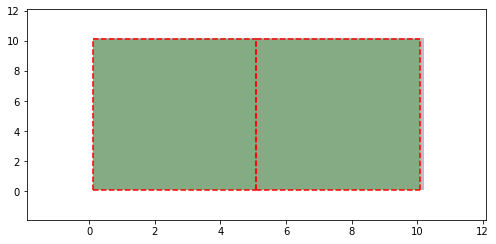

--------------------
deleted
2.4526083 -0.025833333333333333


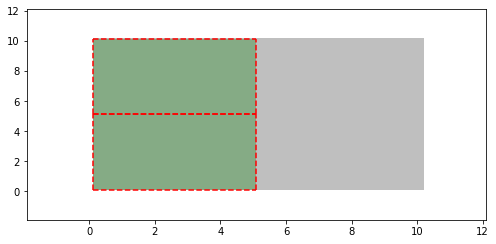

--------------------
deleted
4.7003684 -0.025833333333333333


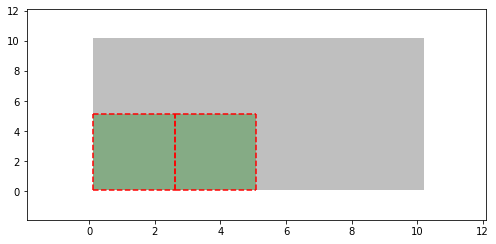

--------------------
6.17785 -0.0175


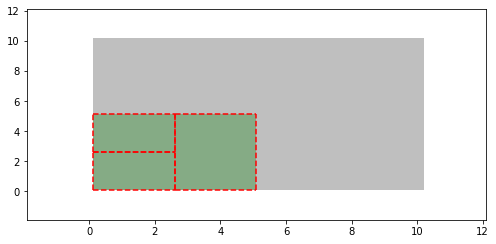

--------------------
6.17785 -0.0175


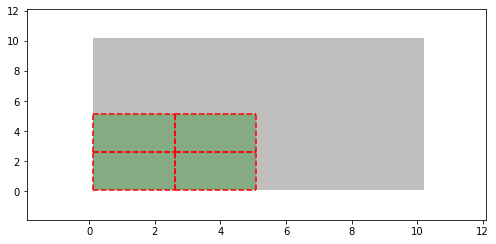

--------------------
6.17785 -0.0175


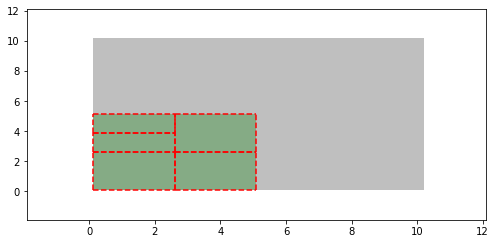

--------------------
6.17785 -0.0175


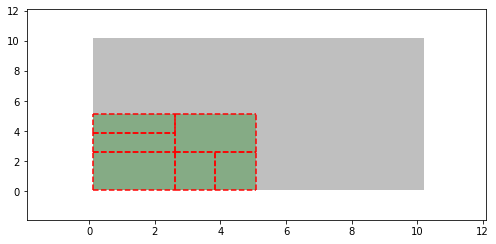

--------------------
deleted
6.17785 -0.0175


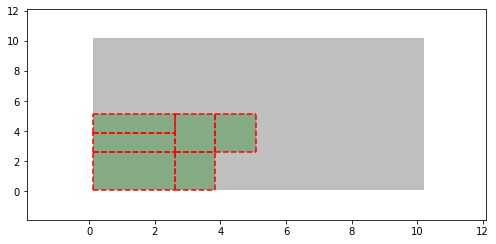

--------------------
deleted
6.17785 -0.0175


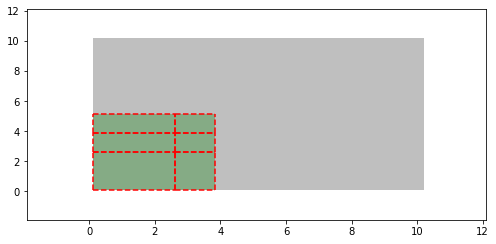

--------------------
deleted
3.493118 -0.006785714285714284


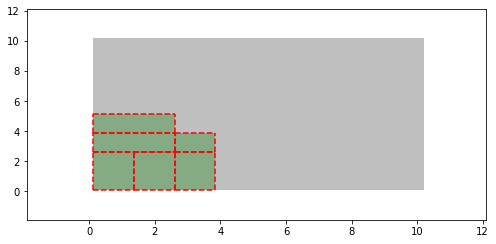

--------------------
deleted
deleted
3.493118 -0.006785714285714284


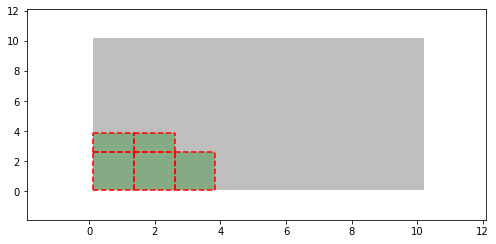

--------------------
3.493118 -0.006785714285714284


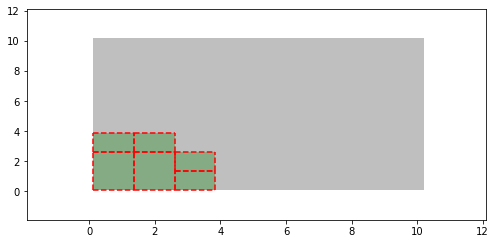

--------------------
deleted
0.5403911 -0.006785714285714284


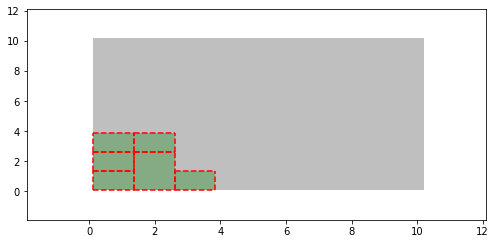

--------------------
deleted
deleted
0.5403911 -0.006785714285714284


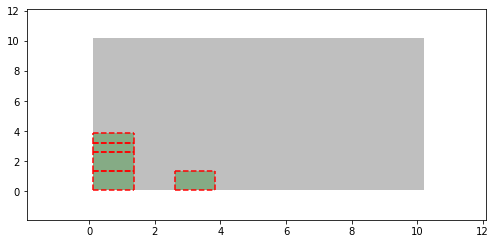

--------------------
deleted
deleted
0.24712855 -0.006785714285714284


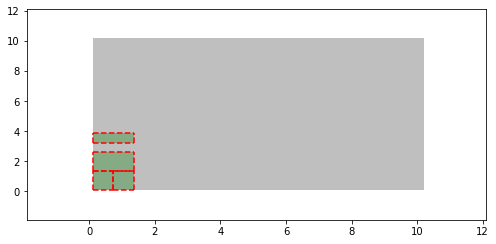

--------------------
deleted
0.24712855 -0.006785714285714284


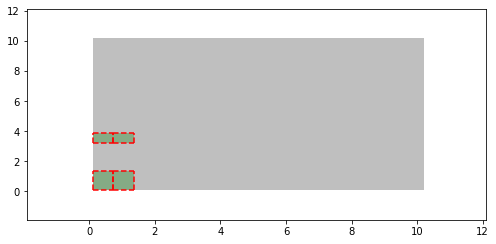

--------------------
deleted
0.062228892 -0.006785714285714284


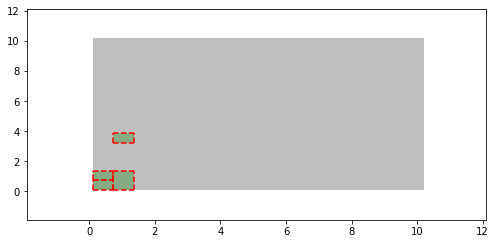

--------------------
Best upper/lower bounds are: -0.006785714285714284 -> 0.062228892
These are the remaining nodes: 
[0.725 0.1  ] ≤ [1.35 1.35]
[0.725 3.225] ≤ [1.35 3.85]
[0.1 0.1] ≤ [0.725 0.725]
[0.1   0.725] ≤ [0.725 1.35 ]



In [24]:
l = [0.1, 0.1]
u = [10.1, 10.1]

BB = Branch_Bound(u, l, verbose=1)
LB, UB, space_left = BB.run()
print('Best upper/lower bounds are:', LB, '->' ,UB)
print(BB)


In [ ]:
fx(np.array([0.1, 0.1]))

0.015000000000000003

In [9]:
!pip list -v | grep torch

torch                   1.5.1+cpu            /home/sina/.local/lib/python3.8/site-packages pip      
torchaudio              0.5.1                /home/sina/.local/lib/python3.8/site-packages pip      
torchvision             0.6.1+cpu            /home/sina/.local/lib/python3.8/site-packages pip      


In [12]:
 print (torch.__version__)

1.5.1+cpu
